## Multiclass classification model using a CNN network in TensorFlow.

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Problem statement: To build a CNN based model which can accurately detect melanoma.

##### Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

##### The dataset consists of  images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

##### Importing Libraries

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import zipfile
import os
import pathlib
import seaborn as sns
import matplotlib.gridspec as gridspec
from PIL import Image

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import warnings
warnings.filterwarnings('ignore')

##### Extracting images from zip folder containing Training and Testing data

In [17]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/CNN_assignment.zip')
zip_ref.extractall()
zip_ref.close()

##### Setting up Directories

In [18]:
data_dir_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

##### Let's convert all image data into `DataFrame` with imagepath and and it's corresponding label

In [19]:
data = {'imgpath': [], 'labels': []}
path_train = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
folders =['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma',
       'melanoma', 'nevus', 'pigmented benign keratosis',
       'seborrheic keratosis', 'squamous cell carcinoma',
       'vascular lesion']

def data_appender(data, path, folder):
    folderpath = os.path.join(path, folder)
    files = os.listdir(folderpath)

    for file in files:
        filepath = os.path.join(folderpath, file)
        data['imgpath'].append(filepath)
        data['labels'].append(folder)

    return data

for folder in folders:
    data = data_appender(data = data, path = path_train, folder = folder)

train_dataset = pd.DataFrame(data)
train_dataset.head()

,imgpath,labels
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis


In [20]:
data_dir_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

##### Let's see all categories we have in our dataset

In [21]:
class_names = train_dataset['labels'].value_counts()
print(f"There are {len(class_names)} classes in the Dataset")
class_names

There are 9 classes in the Dataset


labels
pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: count, dtype: int64

In [22]:
print(f"Total Number of Training images are {np.sum(train_dataset['labels'].value_counts())} ")

Total Number of Training images are 2239 


##### From above Value counts we can say that ,some classes have more training data than others ,let's see

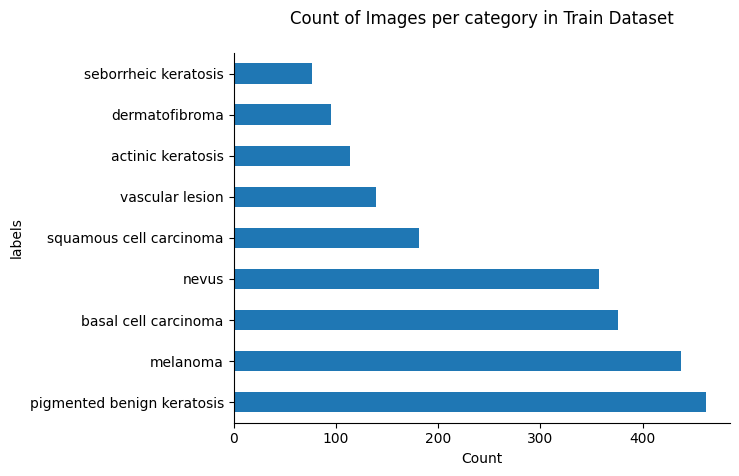

In [23]:
class_names.plot(kind='barh')
plt.xlabel('Count')
plt.title('Count of Images per category in Train Dataset\n')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

##### `melanoma` and `pigmented benign keratosis` have high number of training images than others as shown in graph


##### Let's Visualize one instance of each category in train dataset

In [24]:
train_path = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

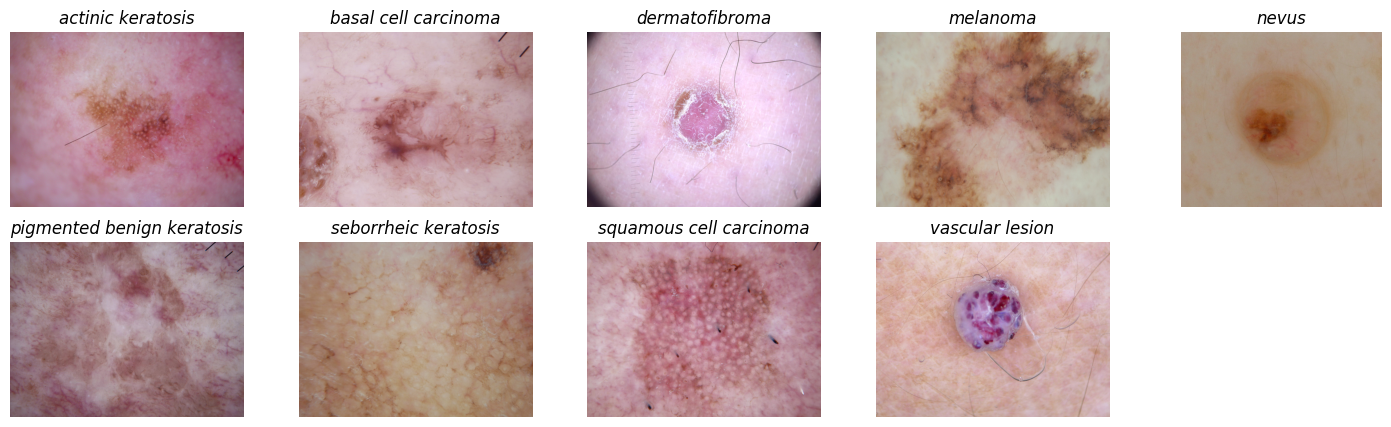

In [25]:
classes = list(train_dataset['labels'].unique())
classes

full_image_path = []
random_images_title = []
for i in classes:
    random_img = random.choice(os.listdir(train_path + i))
    full_image_path.append(train_path + i + '/' + random_img)
    random_images_title.append(i)

plt.figure(figsize=(18,5))
for i, ax in enumerate(full_image_path):
    plt.subplot(2,5,i+1)
    plt.imshow(mpimg.imread(ax))
    plt.title(random_images_title[i],fontstyle='italic')
    plt.axis('off')

#### Training Data Preparations

In [26]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                                batch_size=32,
                                                                 image_size=(180,180),
                                                                 label_mode='categorical',subset='training',validation_split=0.2,
                                                                 seed = 123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [27]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                                     image_size=(180,180),
                                                                     label_mode = 'categorical',subset='validation',validation_split=0.2,
                                                                     seed = 123)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


`tf.data.experimental.AUTOTUNE`   TensorFlow automatically tunes the number of elements to prefetch dynamically at runtime. Prefetching is a technique used to overlap data preprocessing and model execution. By prefetching data, the input pipeline can fetch the next batch of data while the current batch is being processed

`Dataset.cache()`    keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()`    overlaps data preprocessing and model execution while training.

In [28]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Callbacks

#### `ModelCheckpoint`


##### During training, the ModelCheckpoint callback will monitor the validation loss after each epoch.If it finds that the validation loss has improved compared to the previously saved best model,it will overwrite the previous checkpoint with the current model's parameters.This ensures that you always have the best-performing version of the model saved.


In [29]:
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

##### Model Building

##### we will start with Simpler model and complexity as needed

##### Let's create a function to plot training and validation metrics accuracy and loss

In [30]:
def visualization_training_result(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy\n')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower left')
    plt.title('Training and Validation Loss\n')
    plt.show()

In [31]:
model = tf.keras.Sequential([

    tf.keras.layers.Conv2D(16,kernel_size=(3,3),input_shape =(180,180,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),

    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(9,activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 44, 44, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 61952)             0         
                                                                 
 dense (Dense)               (None, 32)                1

In [32]:
model.compile(loss='categorical_crossentropy', optimizer = 'Adam' ,  metrics='accuracy')

In [33]:
history = model.fit(train_ds,validation_data=val_ds,callbacks=[checkpoint],epochs=20)

Epoch 1/20
53/56 [===========================>..] - ETA: 0s - loss: 93.0196 - accuracy: 0.2182 
Epoch 1: val_accuracy improved from -inf to 0.21924, saving model to model.h5
56/56 [==============================] - 18s 67ms/step - loss: 88.1516 - accuracy: 0.2154 - val_loss: 2.1332 - val_accuracy: 0.2192
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 2.0188 - accuracy: 0.2483
Epoch 2: val_accuracy improved from 0.21924 to 0.27517, saving model to model.h5
56/56 [==============================] - 1s 18ms/step - loss: 2.0188 - accuracy: 0.2483 - val_loss: 2.0155 - val_accuracy: 0.2752
Epoch 3/20
53/56 [===========================>..] - ETA: 0s - loss: 1.8097 - accuracy: 0.3868
Epoch 3: val_accuracy improved from 0.27517 to 0.32662, saving model to model.h5
56/56 [==============================] - 1s 18ms/step - loss: 1.8092 - accuracy: 0.3850 - val_loss: 1.9978 - val_accuracy: 0.3266
Epoch 4/20
53/56 [===========================>..] - ETA: 0s - loss: 1.5867 - accurac

In [34]:
model.evaluate(val_ds)

14/14 [==============================] - 0s 9ms/step - loss: 4.3974 - accuracy: 0.3423


[4.39737606048584, 0.34228187799453735]

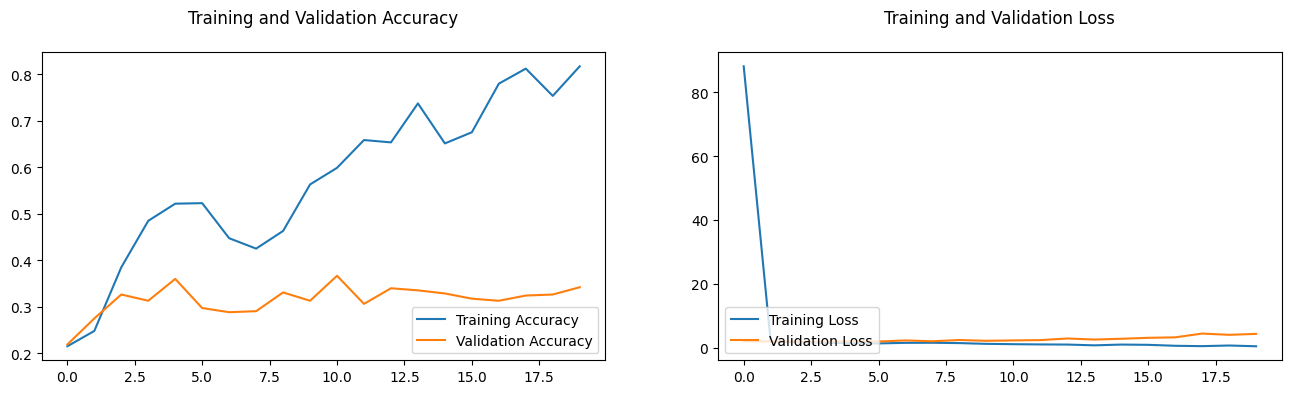

In [35]:
visualization_training_result(history=history ,epochs=20)

##### It's overfitting ,  validation curve must follow training curve  in either respect `accuracy` and `loss`

In [36]:
model_2 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(16,kernel_size=(3,3),input_shape =(180,180,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),

    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(9,activation='softmax')
])

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 89, 89, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 conv2d_4 (Conv2D)           (None, 85, 85, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 118336)           

In [37]:
model_2.compile(loss='categorical_crossentropy' , optimizer = 'Adam' , metrics='accuracy')

In [38]:
history_2 = model_2.fit(train_ds,validation_data=val_ds,callbacks=[checkpoint],epochs=20)

Epoch 1/20
55/56 [============================>.] - ETA: 0s - loss: 36.1348 - accuracy: 0.1869
Epoch 1: val_accuracy did not improve from 0.36689
56/56 [==============================] - 4s 33ms/step - loss: 35.5272 - accuracy: 0.1886 - val_loss: 2.1600 - val_accuracy: 0.2170
Epoch 2/20
55/56 [============================>.] - ETA: 0s - loss: 2.0986 - accuracy: 0.2324
Epoch 2: val_accuracy did not improve from 0.36689
56/56 [==============================] - 2s 28ms/step - loss: 2.0989 - accuracy: 0.2321 - val_loss: 2.0634 - val_accuracy: 0.2371
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 1.9346 - accuracy: 0.2756
Epoch 3: val_accuracy did not improve from 0.36689
56/56 [==============================] - 2s 28ms/step - loss: 1.9323 - accuracy: 0.2773 - val_loss: 2.0095 - val_accuracy: 0.2349
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 1.9613 - accuracy: 0.2785
Epoch 4: val_accuracy did not improve from 0.36689
56/56 [=====================

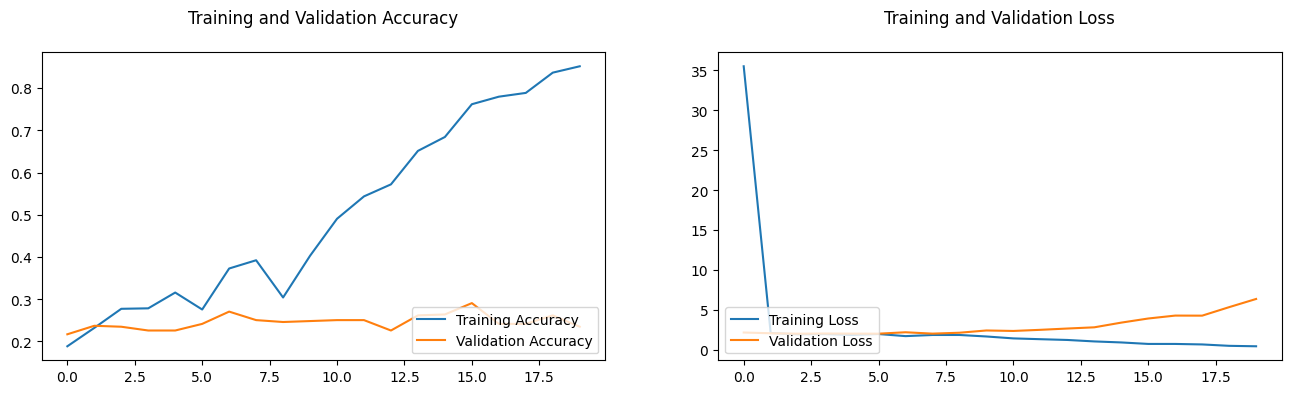

In [39]:
visualization_training_result(history_2,20)

In [40]:
model_3 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32,kernel_size=(3,3),input_shape =(180,180,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),

    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),


    tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9,activation='softmax')
])

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 42, 42, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 21, 21, 128)      

In [41]:
model_3.compile( loss='categorical_crossentropy'  , optimizer = 'Adam' , metrics='accuracy')

In [42]:
history_3 = model_3.fit(train_ds,validation_data=val_ds,callbacks=[checkpoint],epochs=20)

Epoch 1/20
56/56 [==============================] - ETA: 0s - loss: 26.7810 - accuracy: 0.1629
Epoch 1: val_accuracy did not improve from 0.36689
56/56 [==============================] - 7s 63ms/step - loss: 26.7810 - accuracy: 0.1629 - val_loss: 2.1838 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 2.1787 - accuracy: 0.2042
Epoch 2: val_accuracy did not improve from 0.36689
56/56 [==============================] - 3s 57ms/step - loss: 2.1787 - accuracy: 0.2042 - val_loss: 2.1641 - val_accuracy: 0.2058
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 2.1547 - accuracy: 0.2068
Epoch 3: val_accuracy did not improve from 0.36689
56/56 [==============================] - 3s 54ms/step - loss: 2.1550 - accuracy: 0.2065 - val_loss: 2.1463 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - ETA: 0s - loss: 2.1387 - accuracy: 0.2065
Epoch 4: val_accuracy did not improve from 0.36689
56/56 [=====================

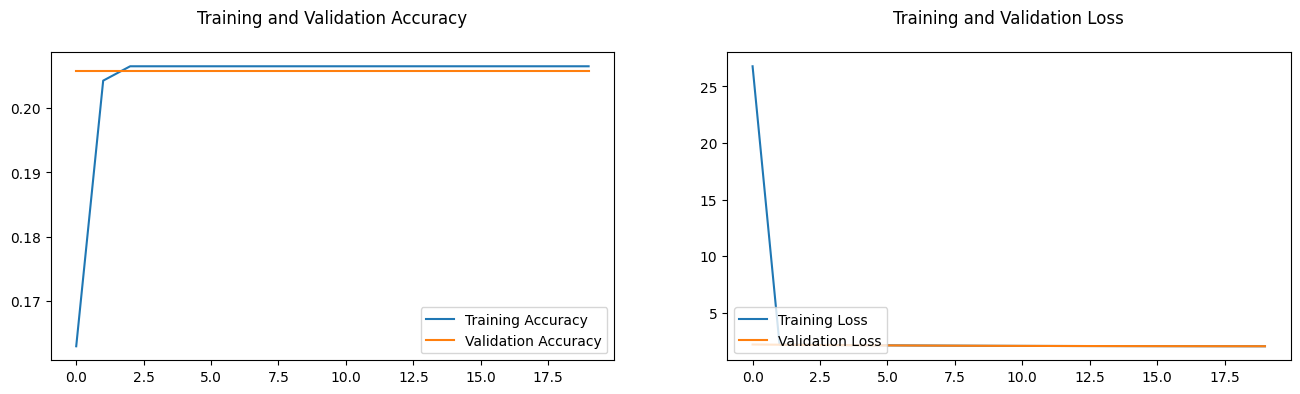

In [43]:
visualization_training_result(history_3 , 20)

In [44]:
model_4 = tf.keras.Sequential([

    tf.keras.layers.Conv2D(32,kernel_size=(3,3),input_shape =(180,180,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),

    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),


    tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2),padding='same'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(128,activation='relu'),

    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(9,activation='softmax')
])

model_4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 44, 44, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 42, 42, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 21, 21, 128)      

In [45]:
model_4.compile(loss='categorical_crossentropy',optimizer = 'Adam',metrics='accuracy')

In [46]:
history_4 = model_4.fit(train_ds,validation_data=val_ds,callbacks=[checkpoint],epochs=20)

Epoch 1/20
55/56 [============================>.] - ETA: 0s - loss: 32.7594 - accuracy: 0.2369
Epoch 1: val_accuracy did not improve from 0.36689
56/56 [==============================] - 4s 52ms/step - loss: 32.2050 - accuracy: 0.2388 - val_loss: 1.8201 - val_accuracy: 0.3311
Epoch 2/20
56/56 [==============================] - ETA: 0s - loss: 1.7980 - accuracy: 0.3951
Epoch 2: val_accuracy did not improve from 0.36689
56/56 [==============================] - 3s 49ms/step - loss: 1.7980 - accuracy: 0.3951 - val_loss: 1.8457 - val_accuracy: 0.3624
Epoch 3/20
55/56 [============================>.] - ETA: 0s - loss: 1.7608 - accuracy: 0.3847
Epoch 3: val_accuracy did not improve from 0.36689
56/56 [==============================] - 3s 50ms/step - loss: 1.7493 - accuracy: 0.3890 - val_loss: 1.8343 - val_accuracy: 0.3669
Epoch 4/20
55/56 [============================>.] - ETA: 0s - loss: 1.7548 - accuracy: 0.3830
Epoch 4: val_accuracy did not improve from 0.36689
56/56 [=====================

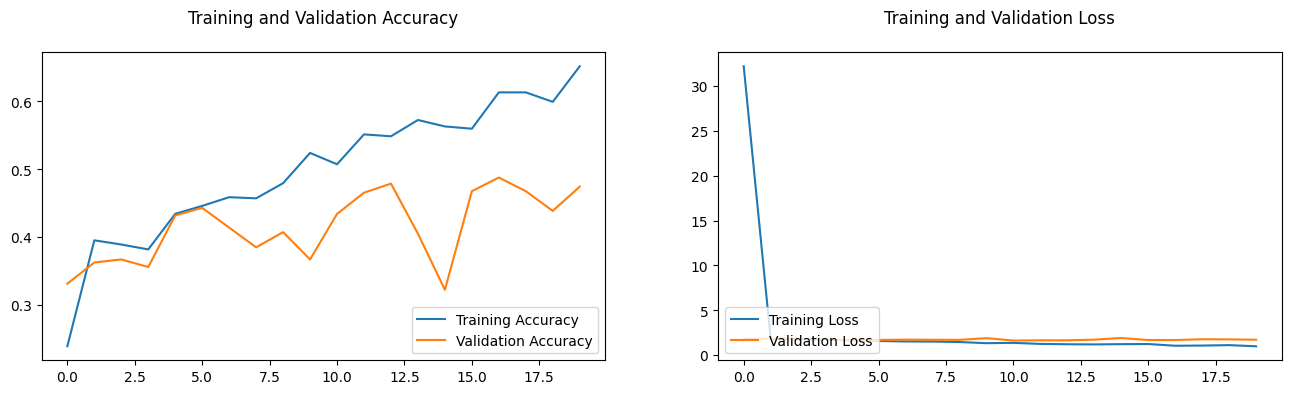

In [47]:
visualization_training_result(history_4,20)

### Augmentor LIbrary

##### As we observing due to class imbalance in training set images in above dataset we are going to rectify with `Augmentor` Library with 800 samples in each training class

In [48]:
!pip install Augmentor

In [49]:
path_to_training_dataset='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
import Augmentor
for i in classes:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.random_distortion(probability=0.5, grid_width=4, grid_height=4, magnitude=8)

    p.sample(800)  #Adding 800 samples per class to make sure that none of the classes are sparse

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7FC02E4C10>: 100%|██████████| 800/800 [00:44<00:00, 17.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7FC02819C0>: 100%|██████████| 800/800 [00:35<00:00, 22.81 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7FC0093FD0>: 100%|██████████| 800/800 [00:37<00:00, 21.39 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B7FE2BEBB50>: 100%|██████████| 800/800 [03:16<00:00,  4.08 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7B7F6E11FE50>: 100%|██████████| 800/800 [03:02<00:00,  4.37 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7FC02E6320>: 100%|██████████| 800/800 [00:36<00:00, 21.64 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B7FC0282620>: 100%|██████████| 800/800 [01:27<00:00,  9.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7FC00D3DF0>: 100%|██████████| 800/800 [00:35<00:00, 22.82 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B7FC03F9A80>: 100%|██████████| 800/800 [00:35<00:00, 22.79 Samples/s]


##### Total number of images create by `Augmentor` library

In [50]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

7200


### Creating Training Dataset and Validation Dataset after Augmentation

In [51]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                                batch_size=32,
                                                                 image_size=(180,180),
                                                                 label_mode='categorical',subset='training',validation_split=0.2,
                                                                 seed = 123)

Found 9439 files belonging to 9 classes.
Using 7552 files for training.


In [52]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                                     image_size=(180,180),
                                                                     label_mode = 'categorical',subset='validation',validation_split=0.2,
                                                                     seed = 123)

Found 9439 files belonging to 9 classes.
Using 1887 files for validation.


In [53]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

##### model_5

In [54]:
model_5 = tf.keras.Sequential([

    tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)),
    tf.keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),


    tf.keras.layers.Conv2D(128,kernel_size=(3,3),activation='relu'),

    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(150,activation='relu'),

    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(9,activation='softmax')
])

model_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 41, 41, 128)      

In [55]:
model_5.compile(loss='categorical_crossentropy'  , optimizer = 'Adam' ,  metrics='accuracy')

In [56]:
history_5 = model_5.fit(train_ds,validation_data=val_ds, epochs=30,callbacks=[checkpoint])

Epoch 1/30
236/236 [==============================] - ETA: 0s - loss: 1.7585 - accuracy: 0.3207
Epoch 1: val_accuracy did not improve from 0.48770
236/236 [==============================] - 57s 81ms/step - loss: 1.7585 - accuracy: 0.3207 - val_loss: 1.4557 - val_accuracy: 0.4229
Epoch 2/30
236/236 [==============================] - ETA: 0s - loss: 1.4192 - accuracy: 0.4548
Epoch 2: val_accuracy improved from 0.48770 to 0.52252, saving model to model.h5
236/236 [==============================] - 13s 54ms/step - loss: 1.4192 - accuracy: 0.4548 - val_loss: 1.2284 - val_accuracy: 0.5225
Epoch 3/30
236/236 [==============================] - ETA: 0s - loss: 1.2589 - accuracy: 0.5307
Epoch 3: val_accuracy improved from 0.52252 to 0.57340, saving model to model.h5
236/236 [==============================] - 13s 55ms/step - loss: 1.2589 - accuracy: 0.5307 - val_loss: 1.1324 - val_accuracy: 0.5734
Epoch 4/30
236/236 [==============================] - ETA: 0s - loss: 1.1079 - accuracy: 0.5857
Epoc

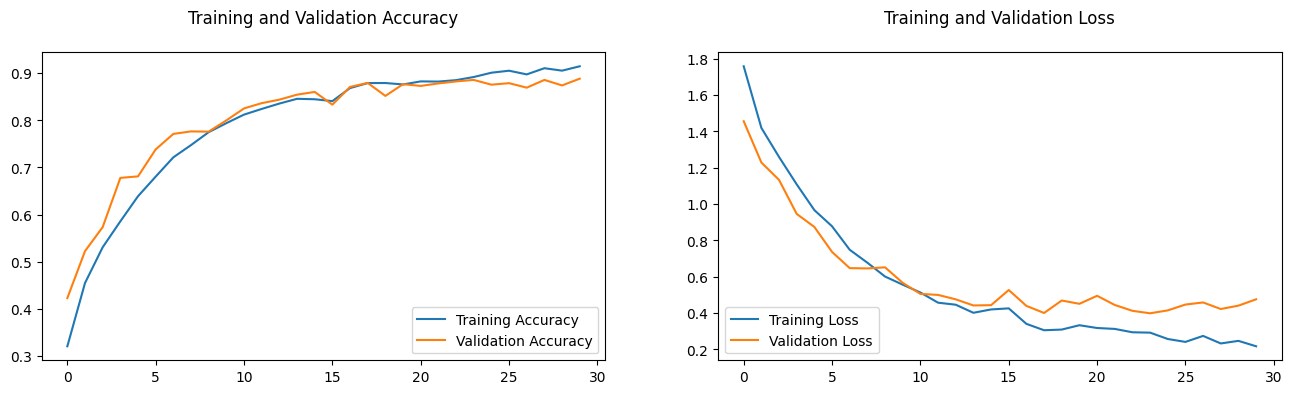

In [57]:
 visualization_training_result(history=history_5 ,epochs=30)

We can See validation Curve is following Traing curve smoothly

In [58]:
model_5.evaluate(val_ds)

59/59 [==============================] - 1s 11ms/step - loss: 0.4748 - accuracy: 0.8882


[0.47475090622901917, 0.8881822824478149]

We are getting Training accuracy as `0.9145` whereas validation accuracy is nearby `0.8881`

### Conclusions & Findings

We started our project with simple CNN artitecture and we slowly increased complexity with succesive models but we are not getting accurate and decent results ,until we Augmented sample images from our training sample images ,so that we don't want our CNN artitectuter to be baised with particular training samples due to Class imbalance.

And finally as expected after augmentation our training and validation accuracy is increased drastically without overfitting.

### Let's See how our model is predicting

1/1 [==============================] - 0s 26ms/step


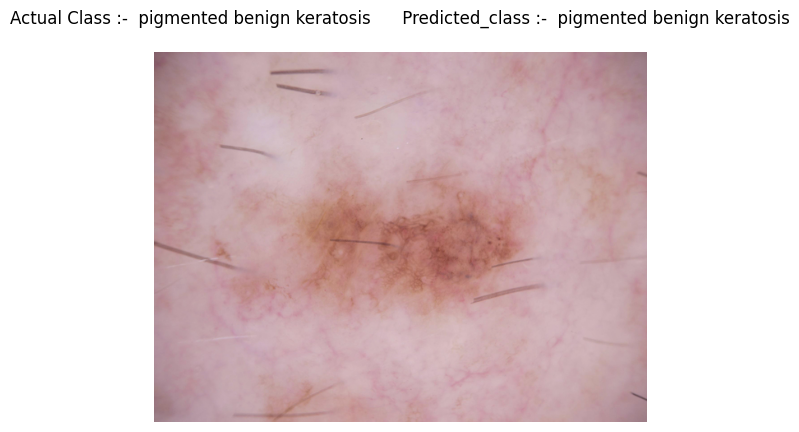

In [86]:

from tensorflow.keras.preprocessing import image

test_image_path = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/'

random_folder = random.choice(os.listdir(test_image_path))
random_image = random.choice(os.listdir(test_image_path + random_folder))
full_image_path = test_image_path + '/' + random_folder + '/' + random_image
img = plt.imshow(mpimg.imread(full_image_path))

sample_image = tf.keras.preprocessing.image.load_img(full_image_path , target_size = (180,180))
sample_image_array = tf.keras.preprocessing.image.img_to_array(sample_image)
sample_image_array = np.expand_dims(sample_image_array,axis=0)

prediction = model.predict(sample_image_array)
class_prediction = np.argmax(prediction)
predicted_class = classes[class_prediction]
random_folder,predicted_class

plt.axis('Off')
plt.title(f"Actual Class :-  {random_folder}      Predicted_class :-  {predicted_class}\n")
plt.show()